*Eduardus Tjitrahardja | @edutjie | 2022*

# Final Project - Segmentation Self-Driving Car

## Importing Libraries

In [1]:
import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.metrics import MeanIoU
from keras.applications.vgg16 import VGG16

import torch, torchmetrics
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import pytorch_lightning as pl
import albumentations as albu

%matplotlib inline

In [2]:
plt.rcParams.update(
    {
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "white",
        "axes.facecolor": "black",
        "axes.edgecolor": "white",
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "grey",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black",
    }
)

## Loading Paths

In [3]:
train_img_path = glob.glob("images/images_prepped_train/*.png")
test_img_path = glob.glob("images/images_prepped_test/*.png")
train_annot_path = glob.glob("images/annotations_prepped_train/*.png")
test_annot_path = glob.glob("images/annotations_prepped_test/*.png")

print("Train images shape:", len(train_img_path))
print("Test images shape:", len(test_img_path))
print("Train Annotations shape:", len(train_annot_path))
print("Test Annotations shape:", len(test_annot_path))

Train images shape: 367
Test images shape: 101
Train Annotations shape: 367
Test Annotations shape: 101


### Make sure our annotation images has same name with our images

In [4]:
train_img_path[0].split("\\")[1], train_annot_path[0].split("\\")[1]

('0001TP_006690.png', '0001TP_006690.png')

In [4]:
annot_sync = True
for i in range(len(train_img_path)):
    img = train_img_path[i].split("\\")[1]
    annot = train_annot_path[i].split("\\")[1]
    if img != annot:
        annot_sync = False
        print(f"{train_img_path[i]} is not the same with {train_annot_path[i]}")
if annot_sync:
    print("All in sync!")

All in sync!


In [6]:
test_img_path[0].split("\\")[1], test_annot_path[0].split("\\")[1]

('0016E5_07959.png', '0016E5_07959.png')

In [5]:
annot_sync = True
for i in range(len(test_img_path)):
    img = test_img_path[i].split("\\")[1]
    annot = test_annot_path[i].split("\\")[1]
    if img != annot:
        annot_sync = False
        print(f"{test_img_path[i]} is not the same with {test_annot_path[i]}")
if annot_sync:
    print("All in sync!")

All in sync!


## Inspecting Image

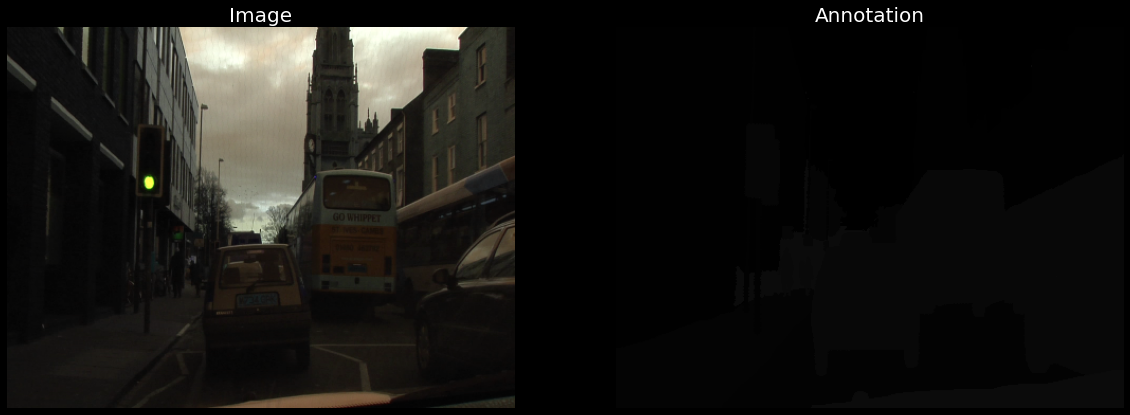

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].set_title("Image", fontsize=20)
ax[0].imshow(cv2.imread(train_img_path[0]))
ax[1].set_title("Annotation", fontsize=20)
ax[1].imshow(cv2.imread(train_annot_path[0]))
ax[0].axis("off")
ax[1].axis("off")

plt.show()

In [9]:
def plot_raw_images(path, title):
    fig, axes = plt.subplots(3, 4, figsize=(20,10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.imread(path[i]))
        ax.set_title(path[i].split("\\")[1])
        ax.axis("off")

    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    plt.show()

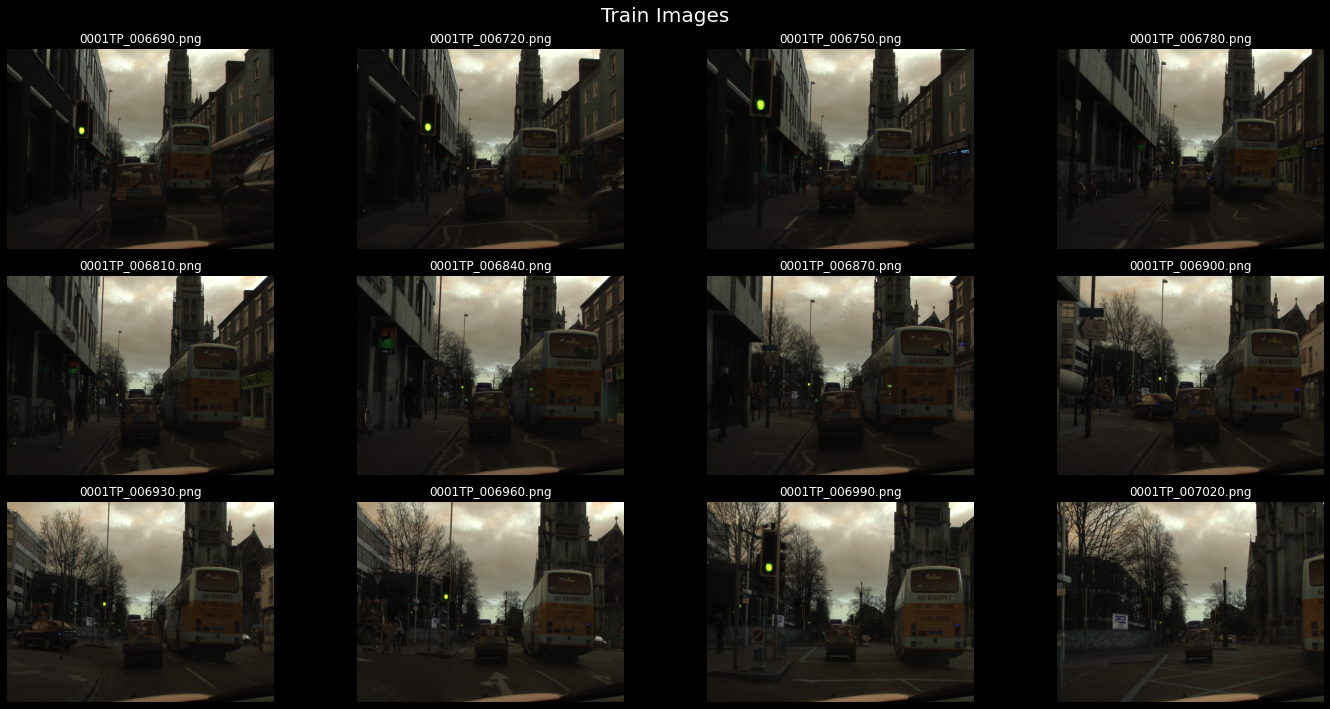

In [10]:
plot_raw_images(train_img_path, "Train Images")

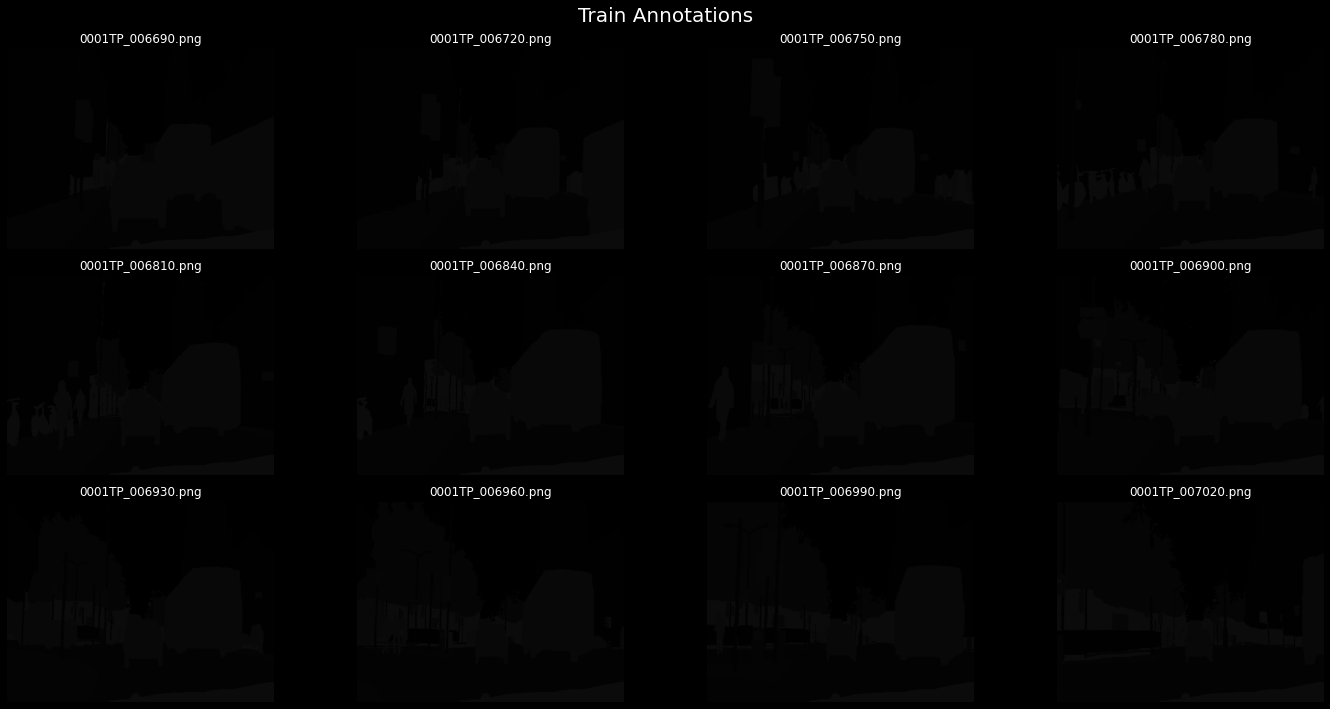

In [11]:
plot_raw_images(train_annot_path, "Train Annotations")

In [12]:
print("Image shape:", cv2.imread(train_img_path[0]).shape)
print("Annotations shape:", cv2.imread(train_annot_path[0]).shape)

Image shape: (360, 480, 3)
Annotations shape: (360, 480, 3)


### Inspect Image Values

In [13]:
cv2.imread(train_img_path[0])[0]

array([[16, 16, 16],
       [16, 16, 16],
       [12, 12, 12],
       ...,
       [20, 19, 15],
       [20, 18, 17],
       [22, 18, 17]], dtype=uint8)

In [14]:
np.unique(cv2.imread(train_img_path[0]))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### Inspect Annotation Values

In [15]:
cv2.imread(train_annot_path[0])[0]

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

In [16]:
np.unique(cv2.imread(train_annot_path[0]))

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11], dtype=uint8)

**Notes:**
- 0 is a background (everything that not belong to target class --> black color)
- There are 11 label classes + 1 Background class in this dataset.
- 11 Label Classes are:
  - Sky
  - Building
  - Pole
  - Road
  - Pavement
  - Tree
  - SignSymbol
  - Fence
  - Car
  - Pedestrian
  - Bicyclist

### Recolor Annotations

In [7]:
class_colors = [
    (128, 0, 0),
    (170, 110, 40),
    (128, 128, 0),
    (0, 128, 128),
    (0, 0, 128),
    (230, 25, 75),
    (245, 130, 48),
    (255, 255, 25),
    (210, 245, 60),
    (240, 50, 230),
    (128, 128, 128),
    (220, 190, 255),
]

In [4]:
def recolor_annot(seg, colors, n_classes):
    recolored_seg = np.zeros_like(seg)

    for n in range(n_classes):
        for i in range(3):
            recolored_seg[:, :, i] += ((seg[:, :, 0] == n) * colors[n][i]).astype('uint8')

    return recolored_seg

In [19]:
recolored_seg = recolor_annot(cv2.imread(train_annot_path[0]), class_colors, 12)

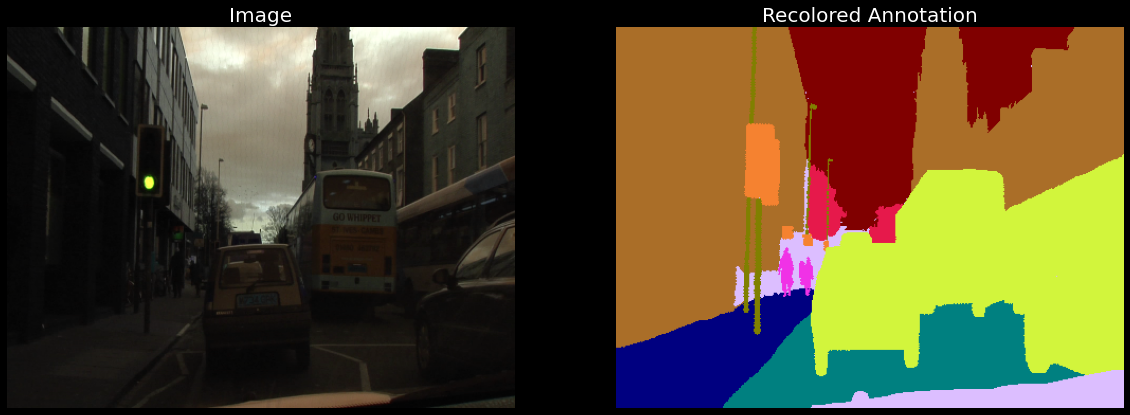

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].set_title("Image", fontsize=20)
ax[0].imshow(cv2.imread(train_img_path[0]))
ax[1].set_title("Recolored Annotation", fontsize=20)
ax[1].imshow(recolored_seg)
ax[0].axis("off")
ax[1].axis("off")

plt.show()

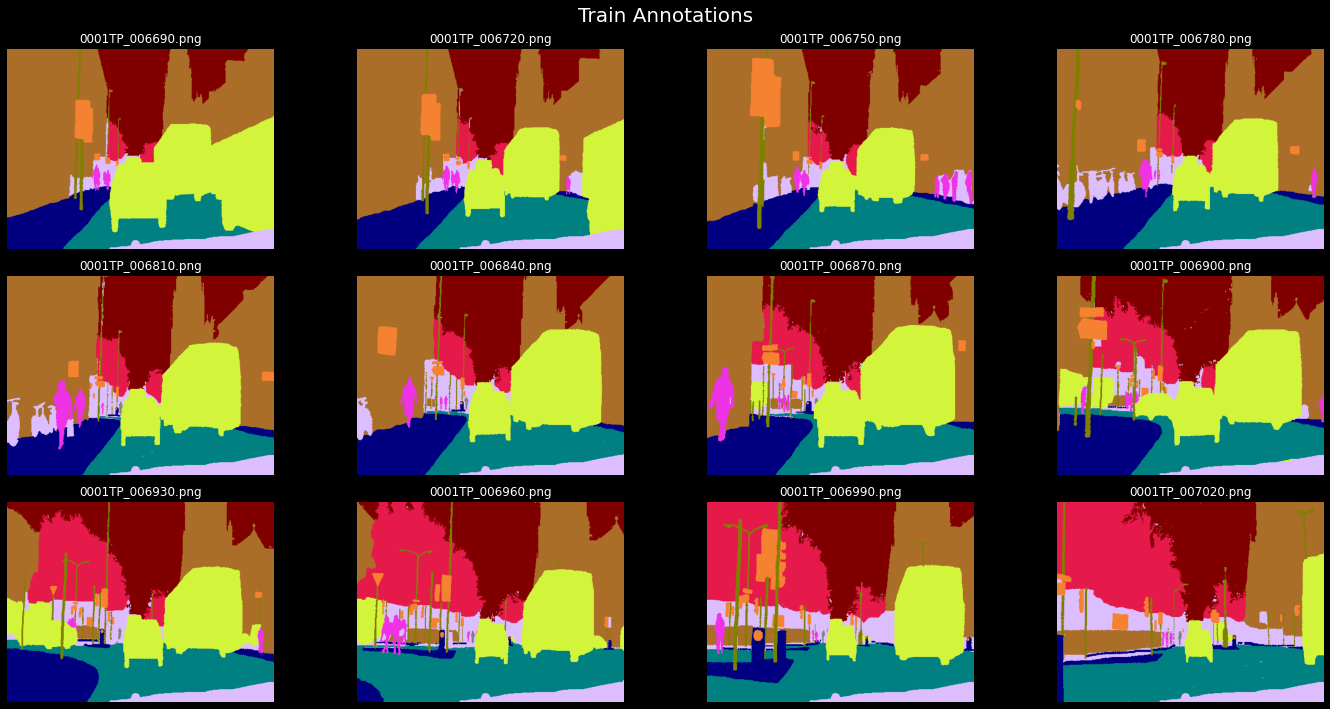

In [21]:
fig, axes = plt.subplots(3, 4, figsize=(20,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(recolor_annot(cv2.imread(train_annot_path[i]), class_colors, 12))
    ax.set_title(train_annot_path[i].split("\\")[1])
    ax.axis("off")

fig.suptitle("Train Annotations", fontsize=20)
fig.tight_layout()
plt.show()

## Loading and Resizing Images

In [4]:
def load_images(paths, flags=None, size=None):
    images = []
    for path in paths:
        img = cv2.imread(path, flags)
        img = cv2.resize(img, size)
        images.append(img)
    return np.array(images)

In [5]:
size=(128, 128)

In [6]:
train_img = load_images(train_img_path, size=size)
test_img = load_images(test_img_path, size=size)
train_annot = load_images(train_annot_path, flags=cv2.IMREAD_UNCHANGED, size=size)
test_annot = load_images(test_annot_path, flags=cv2.IMREAD_UNCHANGED, size=size)

print("Train images shape:", train_img.shape)
print("Test images shape:", test_img.shape)
print("Train Annotations shape:", train_annot.shape)
print("Test Annotations shape:", test_annot.shape)

Train images shape: (367, 128, 128, 3)
Test images shape: (101, 128, 128, 3)
Train Annotations shape: (367, 128, 128)
Test Annotations shape: (101, 128, 128)


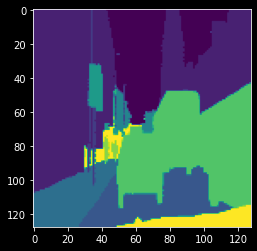

In [7]:
plt.imshow(train_annot[0])
plt.show()

## Data Preprocessing

### One Hot Encoding Labels

In [7]:
num_class = len(np.unique(train_annot))
print("Number of classes:", num_class)
print("Classes:", np.unique(train_annot))

Number of classes: 12
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [8]:
y_train = to_categorical(train_annot, num_class)
y_test = to_categorical(test_annot, num_class)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (367, 128, 128, 12)
y_test shape: (101, 128, 128, 12)


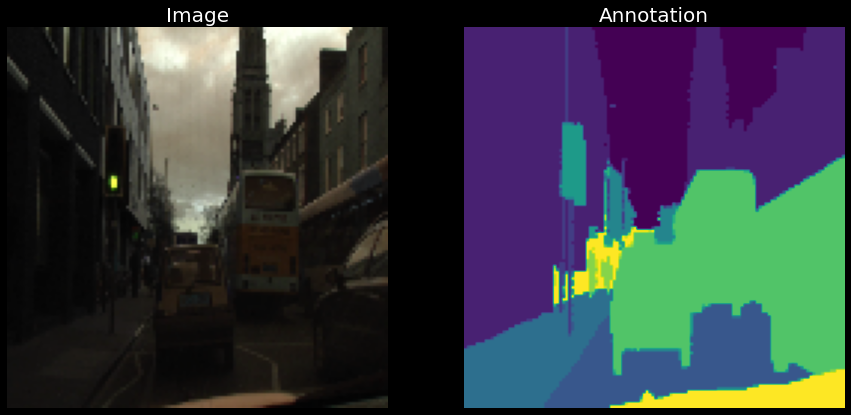

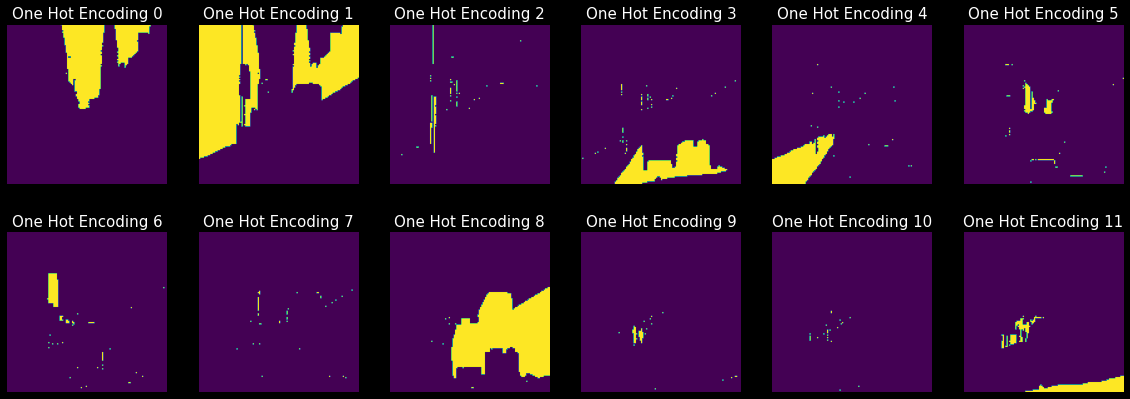

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].set_title("Image", fontsize=20)
ax[0].imshow(train_img[0])
ax[1].set_title("Annotation", fontsize=20)
ax[1].imshow(train_annot[0])
ax[0].axis("off")
ax[1].axis("off")

fig2, ax2 = plt.subplots(2, 6, figsize=(20, 7))
for i, ax in enumerate(ax2.flat):
    ax.imshow(y_train[0][:,:,i])
    ax.set_title(f"One Hot Encoding {i}", fontsize=15)
    ax.axis("off")
plt.show()

### Normalizing Images

In [9]:
X_train = train_img.astype('float32') / 255.0
X_test = test_img.astype('float32') / 255.0

X_train[0, 0, :5]

array([[0.05490196, 0.05490196, 0.05490196],
       [0.04705882, 0.04705882, 0.04705882],
       [0.04313726, 0.04313726, 0.04313726],
       [0.04705882, 0.04705882, 0.04705882],
       [0.04705882, 0.04705882, 0.04705882]], dtype=float32)

## Helper Functions

### Pixel-wise Cross Entropy Loss Function

In [10]:
def pixel_wise_cross_entropy(y_true, y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return(tf.reduce_sum(loss))

### Other Functions

In [11]:
def plot_history(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    ax[0].plot(history.history["loss"], label="loss")
    ax[0].plot(history.history["val_loss"], label="val_loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend()

    ax[1].plot(history.history["accuracy"], label="accuracy")
    ax[1].plot(history.history["val_accuracy"], label="val_accuracy")
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    plt.show()

In [12]:
def eval_model(model, X_train, y_train, X_test, y_test):
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Train: {train_acc:.3f}, Test: {test_acc:.3f}")

In [13]:
def calculate_mean_iou(y_test, y_pred, num_class):
    # for indiviual class: iou = true_positives / (true_positives + false_positives + false_negatives)
    m = MeanIoU(num_classes=num_class)
    m.update_state(y_test, y_pred)
    print("MeanIou:", m.result().numpy())
    
    values = np.array(m.get_weights()).reshape(num_class, num_class)
    val = 0
    total = 0
    res = []

    for i in range(num_class):
        val = values[i, i]
        sum1 = 0

        for j in range(num_class):
            sum1 = values[i, j] + sum1
        sum2 = 0

        for x in range(num_class):
            if x != i:
                sum2 = values[x, i] + sum2
            else:
                continue
        total = sum1 + sum2
        res.append(val / total)
        print(f"IoU class {i}: {res[i]}")

    fig, ax = plt.subplots(figsize=(15, 7))
    plt.bar(range(num_class), res)
    plt.xticks(range(num_class))
    for i in ax.containers:
        ax.bar_label(
            i,
        )
    plt.show()
        
    return m

In [14]:
def plot_prediction(y_pred):
    fig, axes = plt.subplots(5, 3, figsize=(20,30))

    for i in range(5):
        axes[i, 0].set_title("Test Image", fontsize=20)
        axes[i, 0].imshow(test_img[i * 10])
        axes[i, 0].axis("off")
        axes[i, 1].set_title("Test Annotation", fontsize=20)
        axes[i, 1].imshow(test_annot[i * 10])
        axes[i, 1].axis("off")
        axes[i, 2].set_title("Test Prediction", fontsize=20)
        axes[i, 2].imshow(y_pred[i * 10])
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# U-Net

## Modeling and Training Model

### Defining U-Net

In [15]:
def UNet(image_size, ch_in=1, ch_out=2): # 1 is for gray image, 2 for binary-class segmentation
    inputs = layers.Input(shape=(*image_size, ch_in), name='input')

    # The contraction path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4) # optional to tackle overfitting issue
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # The bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5) # optional to tackle overfitting issue

    # The expansion path
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2,2))(drop5))
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2,2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2,2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2,2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    conv9 = layers.Conv2D(ch_out, 1, activation='softmax')(conv9)

    outputs = conv9
    
    model = keras.Model(inputs, outputs)

    return model

### Training with U-Net Model

In [16]:
train_shape = X_train[0].shape
train_shape

(128, 128, 3)

In [17]:
unet_model = UNet(image_size=train_shape[:2], ch_in=train_shape[2], ch_out=num_class)
unet_model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [26]:
y_train[0].shape

(128, 128)

In [18]:
# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(
    "checkpoints/unet_best_model.hdf5",
    monitor="val_accuracy",
    verbose=1,
    mode="max",
    save_best_only=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=10, min_lr=0.0001, mode="min"
)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="min")

unet_history = unet_model.fit(
    X_train,
    y_train,
    batch_size=4,
    epochs=50,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, reduce_lr, early_stopping],
)

Epoch 1/50
92/92 [==============================] - ETA: 0s - loss: 2.1878 - accuracy: 0.4505
Epoch 1: val_accuracy improved from -inf to 0.61750, saving model to checkpoints\unet_best_model.hdf5
92/92 [==============================] - 18s 113ms/step - loss: 2.1878 - accuracy: 0.4505 - val_loss: 1.2498 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 1.0430 - accuracy: 0.6724
Epoch 2: val_accuracy did not improve from 0.61750
92/92 [==============================] - 7s 74ms/step - loss: 1.0430 - accuracy: 0.6724 - val_loss: 1.1591 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 0.9451 - accuracy: 0.6987
Epoch 3: val_accuracy improved from 0.61750 to 0.62606, saving model to checkpoints\unet_best_model.hdf5
92/92 [==============================] - 7s 82ms/step - loss: 0.9451 - accuracy: 0.6987 - val_loss: 1.0300 - val_accuracy: 0.6261 - lr: 0.0010
Epoch 4/50
92/92 [===========

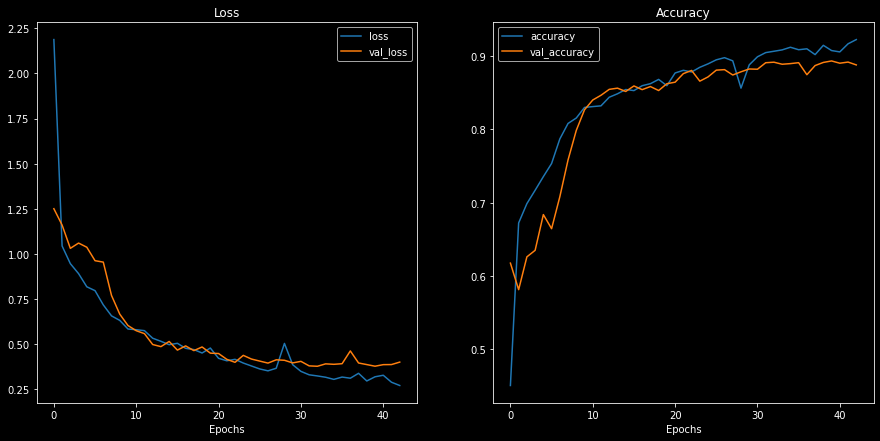

In [19]:
plot_history(unet_history)

In [20]:
eval_model(unet_model, X_train, y_train, X_test, y_test)

Train: 0.924, Test: 0.888


In [21]:
unet_best_model = keras.models.load_model("checkpoints/unet_best_model.hdf5")
eval_model(unet_best_model, X_train, y_train, X_test, y_test)

Train: 0.918, Test: 0.893


**Observations:**
- This model is very good, we can see that the val_accuracy and the accuracy fits in the graph.
- The model accuracy is also very decent with **0.88548** being the highest.

## Predicting

In [36]:
unet_y_pred = unet_best_model.predict(X_test)
unet_y_pred = np.argmax(unet_y_pred, axis=-1)
print("y_pred Shape:", unet_y_pred.shape)
unet_y_pred[0, 0, :]

4/4 [==============================] - 1s 198ms/step
y_pred Shape: (101, 128, 128)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

### Evaluating Model

In [25]:
y_test_argmax = np.argmax(y_test, axis=-1)
print("y_test Shape:", y_test_argmax.shape)
y_test_argmax[0, 0, :]

y_test Shape: (101, 128, 128)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

MeanIou: 0.5366971
IoU class 0: 0.9370090526302088
IoU class 1: 0.8004299494798359
IoU class 2: 0.021346344438514905
IoU class 3: 0.9528939783755618
IoU class 4: 0.8117941227738007
IoU class 5: 0.8571965095938799
IoU class 6: 0.24372230428360414
IoU class 7: 0.491766647622675
IoU class 8: 0.46028984498686476
IoU class 9: 0.3014468667513931
IoU class 10: 0.4008155983178285
IoU class 11: 0.1616546265703459


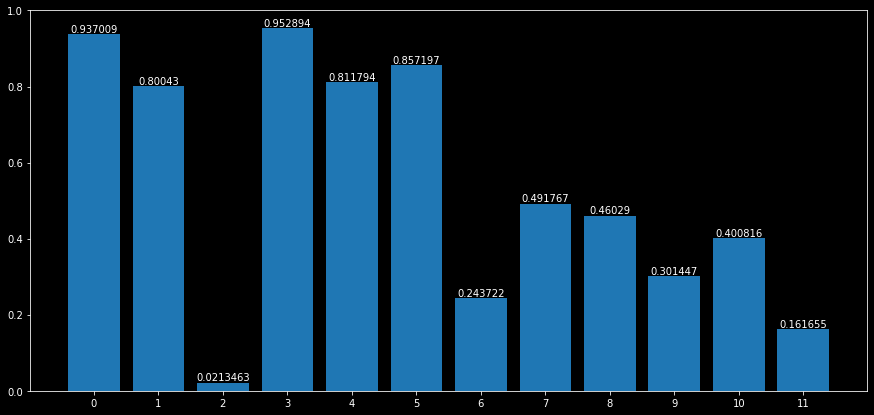

In [39]:
unet_m = calculate_mean_iou(y_test_argmax, unet_y_pred, num_class)

### Plotting Prediction Image

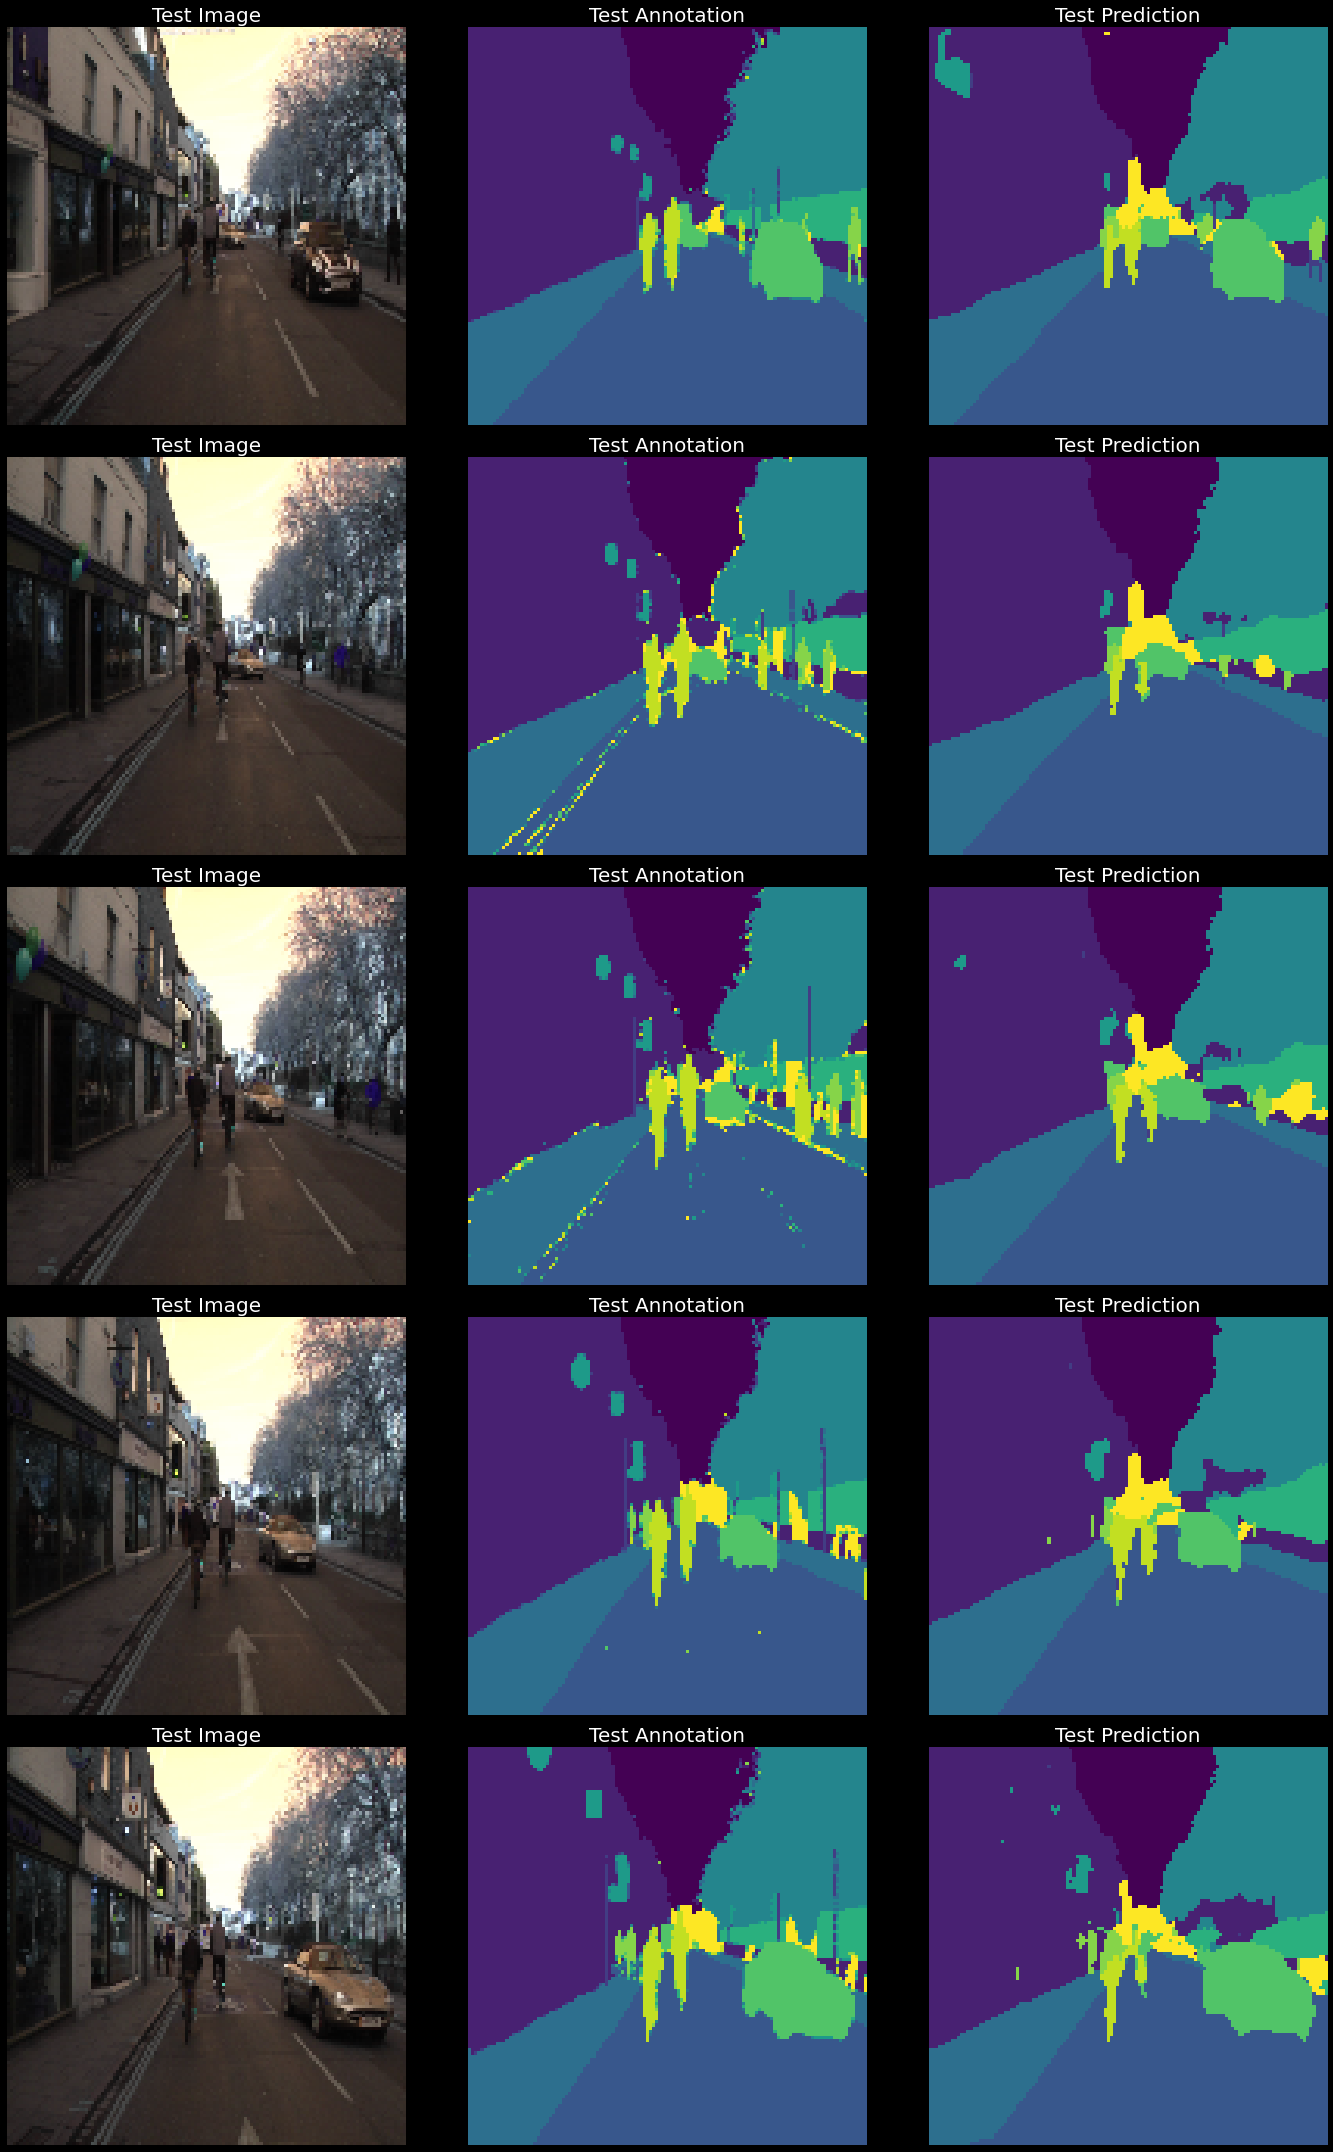

In [41]:
plot_prediction(unet_y_pred)

**Observations:**
- The prediction is pretty good!
- I'm satisfied with it.

# FCN

## Modeling and Training Model

### Defining FCN8s

In [13]:
def FCN8s(image_size, ch_in=3, ch_out=3):
    inputs = layers.Input(shape=(*image_size, ch_in), name='input')
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    
    f3 = vgg16.get_layer('block3_pool').output
    f4 = vgg16.get_layer('block4_pool').output
    f5 = vgg16.get_layer('block5_pool').output
    
    f5_conv1 = layers.Conv2D(filters=4086, kernel_size=7, padding='same', activation='relu')(f5)
    f5_drop1 = layers.Dropout(0.5)(f5_conv1)
    f5_conv2 = layers.Conv2D(filters=4086, kernel_size=1, padding='same', activation='relu')(f5_drop1)
    f5_drop2 = layers.Dropout(0.5)(f5_conv2)
    f5_conv3 = layers.Conv2D(filters=ch_out, kernel_size=1, padding='same', activation=None)(f5_drop2)
    
    f5_conv3_x2 = layers.Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2, use_bias=False, padding='same', activation='relu')(f5)
    f4_conv1 = layers.Conv2D(filters=ch_out, kernel_size=1, padding='same', activation=None)(f4)
    
    merge1 = layers.add([f4_conv1, f5_conv3_x2])
    
    merge1_x2 = layers.Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2, use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = layers.Conv2D(filters=ch_out, kernel_size=1, padding='same', activation=None)(f3)
    
    merge2 = layers.add([f3_conv1, merge1_x2])
    
    outputs = layers.Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8, padding='same', activation=None)(merge2)
    
    model = keras.Model(inputs, outputs)
    
    return model

### Training with FCN8s Model

In [14]:
train_shape = X_train[0].shape
train_shape

(128, 128, 3)

In [18]:
fcn8s_model = FCN8s(image_size=train_shape[:2], ch_in=train_shape[2], ch_out=num_class)
fcn8s_model.compile(optimizer="Adam", loss=pixel_wise_cross_entropy, metrics=["accuracy"])
fcn8s_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [19]:
# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(
    "checkpoints/fcn8s_best_model2.hdf5",
    monitor="val_accuracy",
    verbose=1,
    mode="max",
    save_best_only=True,
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10, min_lr=0.0001, mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="min")

fcn8s_history = fcn8s_model.fit(
    X_train,
    y_train,
    batch_size=4,
    epochs=50,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, reduce_lr, early_stopping],
)

Epoch 1/50
92/92 [==============================] - ETA: 0s - loss: 99472.1094 - accuracy: 0.5228 
Epoch 1: val_accuracy improved from -inf to 0.55469, saving model to checkpoints\fcn8s_best_model2.hdf5
92/92 [==============================] - 5s 41ms/step - loss: 99472.1094 - accuracy: 0.5228 - val_loss: 81154.8750 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 2/50
91/92 [============================>.] - ETA: 0s - loss: 65227.7188 - accuracy: 0.6860
Epoch 2: val_accuracy improved from 0.55469 to 0.61756, saving model to checkpoints\fcn8s_best_model2.hdf5
92/92 [==============================] - 3s 37ms/step - loss: 64986.9961 - accuracy: 0.6866 - val_loss: 67460.3281 - val_accuracy: 0.6176 - lr: 0.0010
Epoch 3/50
91/92 [============================>.] - ETA: 0s - loss: 57261.8477 - accuracy: 0.7279
Epoch 3: val_accuracy improved from 0.61756 to 0.64650, saving model to checkpoints\fcn8s_best_model2.hdf5
92/92 [==============================] - 3s 38ms/step - loss: 57163.7891 - accuracy: 

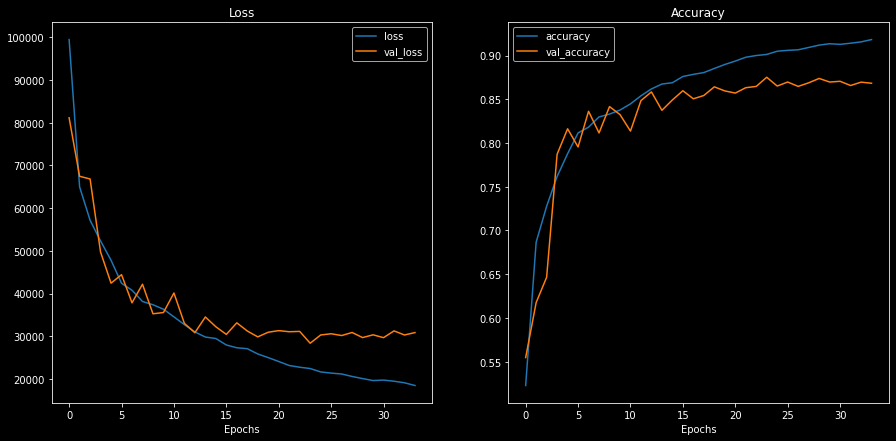

In [20]:
plot_history(fcn8s_history)

In [21]:
eval_model(fcn8s_model, X_train, y_train, X_test, y_test)

Train: 0.919, Test: 0.868


In [22]:
fcn8s_best_model = keras.models.load_model("checkpoints/fcn8s_best_model2.hdf5", custom_objects={'pixel_wise_cross_entropy': pixel_wise_cross_entropy})
eval_model(fcn8s_best_model, X_train, y_train, X_test, y_test)

Train: 0.903, Test: 0.875


**Observations:**
- The val and train accuracy fits in the graph
- The best val accuracy that the model scores is 0.877 slightly less than the U-Net model achieved.

## Predicting

In [23]:
fcn8s_y_pred = fcn8s_best_model.predict(X_test)
fcn8s_y_pred = np.argmax(fcn8s_y_pred, axis=-1)
print("y_pred Shape:", fcn8s_y_pred.shape)
fcn8s_y_pred[0, 0, :]

4/4 [==============================] - 1s 119ms/step
y_pred Shape: (101, 128, 128)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

### Evaluating Model

In [26]:
y_test_argmax[0, 0, :]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

MeanIou: 0.49913773
IoU class 0: 0.9114578031151379
IoU class 1: 0.8046490198444476
IoU class 2: 0.0006941230911614993
IoU class 3: 0.9219393093826299
IoU class 4: 0.7523293191400153
IoU class 5: 0.853962795997721
IoU class 6: 0.14930801568182892
IoU class 7: 0.44599886838922975
IoU class 8: 0.580107849011384
IoU class 9: 0.10368331367151658
IoU class 10: 0.32023001931802864
IoU class 11: 0.14529273778143212


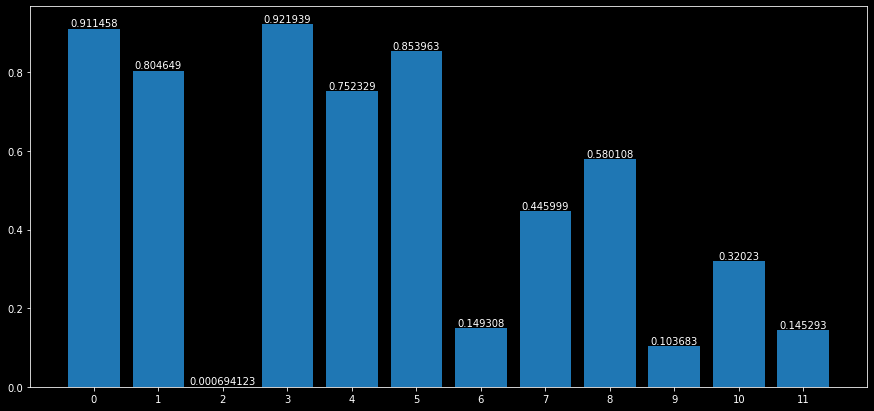

In [31]:
fcn8s_m = calculate_mean_iou(y_test_argmax, fcn8s_y_pred, num_class)

### Plotting Prediction Image

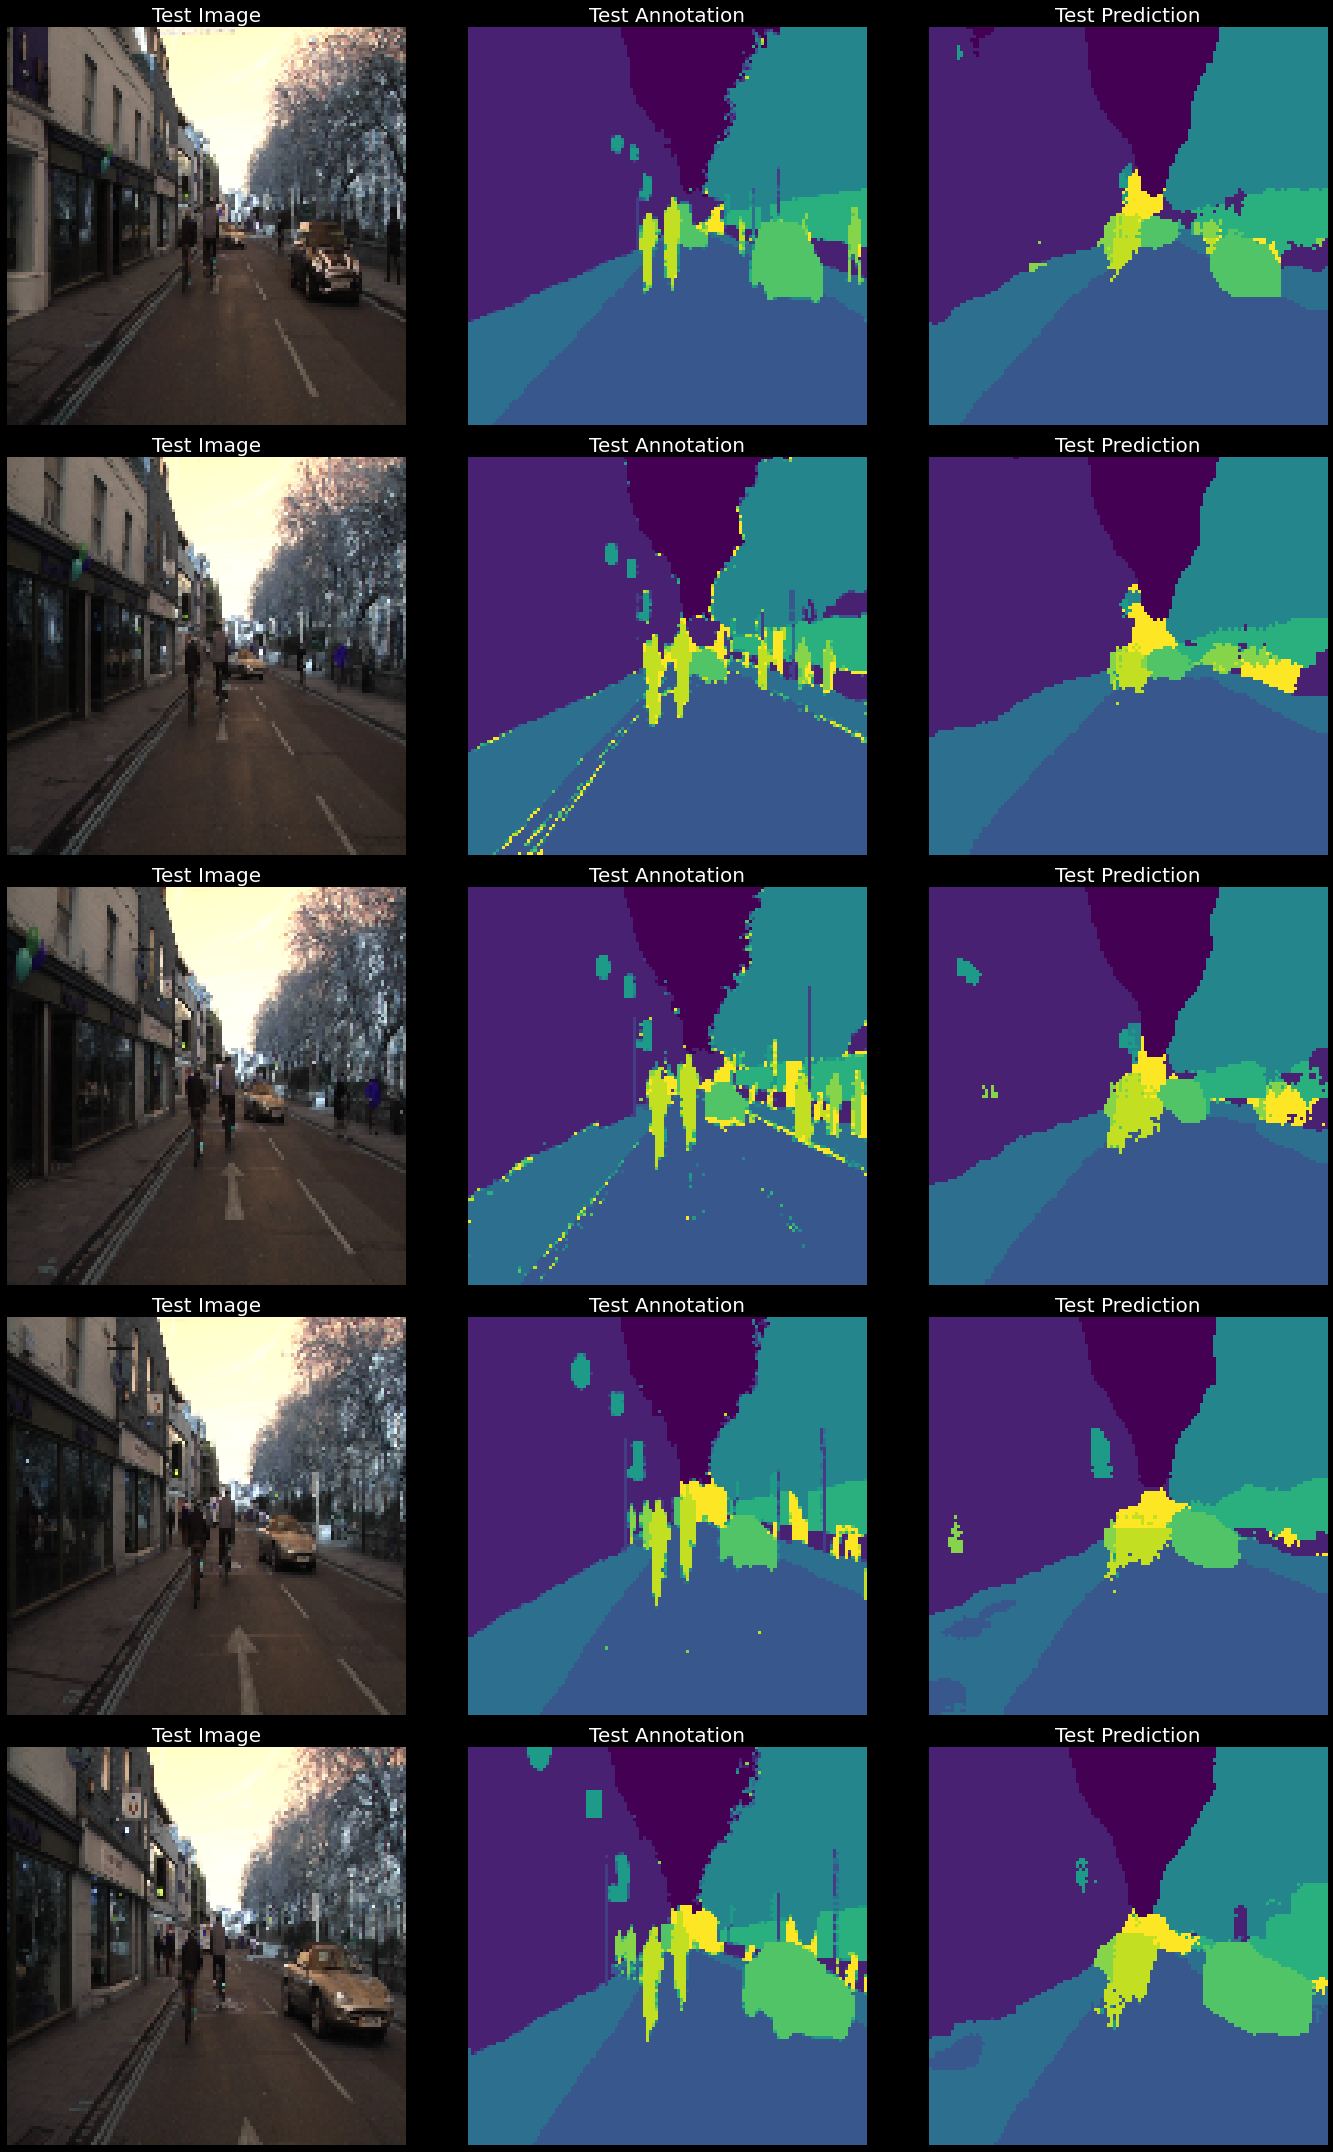

In [32]:
plot_prediction(fcn8s_y_pred)

# U-Net x Mobile-Net v2

## Modeling and Training Model

### Training with U-Net Model

In [20]:
train_shape = X_train[0].shape
train_shape

(128, 128, 3)

In [21]:
ENCODER = "mobilenet_v2"
ENCODER_WEIGHTS = "imagenet"

In [22]:
umob_model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=num_class,
    activation="softmax",
    in_channels=train_shape[2],
)
preprocess_input = smp.encoders.get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)

In [23]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [24]:
class Dataset(BaseDataset):
    def __init__(
        self,
        X,
        y,
        preprocessing=None,
    ):
        self.images = X
        self.mask = y
        
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = self.images[i]
        mask = self.mask[i]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images)

In [25]:
train_dataset = Dataset(
    X_train,
    y_train,
    preprocessing=get_preprocessing(preprocess_input),
)

valid_dataset = Dataset(
    X_test,
    y_test,
    preprocessing=get_preprocessing(preprocess_input),
)

train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

In [26]:
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=umob_model.parameters(), lr=0.001)])

train_epoch = TrainEpoch(
    umob_model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device="cuda",
    verbose=True,
)

valid_epoch = ValidEpoch(
    umob_model,
    loss=loss,
    metrics=metrics,
    device="cuda",
    verbose=True,
)

In [ ]:
y_train[0].shape

(128, 128)

In [21]:
max_score = 0

for i in range(0, 50):
    print(f'\nEpoch: {i}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(umob_model, './checkpoints/umob_best_model.pth')
        print('Model saved!')
        
    if i == 35:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-4!')


Epoch: 0
train:   0%|          | 0/367 [00:00<?, ?it/s]

d:\miniconda3\envs\tf\lib\site-packages\segmentation_models_pytorch\base\modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|██████████| 101/101 [00:01<00:00, 63.67it/s, dice_loss - 0.4358, iou_score - 0.3949]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 64.54it/s, dice_loss - 0.3961, iou_score - 0.4349]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 59.27it/s, dice_loss - 0.3685, iou_score - 0.4633]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 57.90it/s, dice_loss - 0.3785, iou_score - 0.4531]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 59.80it/s, dice_loss - 0.3602, iou_score - 0.4716]
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [00:01<00:00, 55.93it/s, dice_loss - 0.3676, iou_score - 0.4639]

Epoch: 6
valid: 100%|██████████| 101/101 [00:01<00:00, 61.28it/s, dice_loss - 0.3683, iou_score - 0.4631]

Epoch: 7
valid: 100%|██████████| 101/101 [00:01<00:00, 57.33it/s, dice_loss - 0.3709, iou_score - 0.4604]

Epoch: 8
valid: 100%|██████████| 101/101 [00:01<00:00, 62.32it/s, dice_loss - 0.3039, iou_score - 0.5

In [28]:
# load best saved checkpoint
umob_best_model = torch.load('./checkpoints/umob_best_model.pth')
test_loader = DataLoader(valid_dataset)
test_epoch = ValidEpoch(
    umob_best_model,
    loss=loss,
    metrics=metrics,
    device="cuda",
    verbose=True,
)
logs = test_epoch.run(test_loader)
logs

valid: 100%|██████████| 101/101 [00:01<00:00, 61.88it/s, dice_loss - 0.1324, iou_score - 0.768] 


{'dice_loss': 0.13236821819059919, 'iou_score': 0.7680194425110769}

**Observations:**
- The model iou score is very decent with **0.768** being the highest.

## Predicting

In [30]:
umob_y_pred = []

for batch in valid_dataset:
    image, mask = batch
    x_tensor = torch.from_numpy(image).to("cuda").unsqueeze(0)
    pred_mask = umob_best_model.predict(x_tensor)
    pred_mask = (pred_mask.squeeze().cpu().numpy().round())
    umob_y_pred.append(pred_mask)

umob_y_pred = np.array(umob_y_pred)
umob_y_pred.shape

(101, 12, 128, 128)

In [31]:
umob_y_pred = np.argmax(umob_y_pred, axis=1)
print("y_pred Shape:", umob_y_pred.shape)
umob_y_pred[0, 0, :]

y_pred Shape: (101, 128, 128)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

### Evaluating Model

In [32]:
y_test_argmax = np.argmax(y_test, axis=-1)
print("y_test Shape:", y_test_argmax.shape)
y_test_argmax[0, 0, :]

y_test Shape: (101, 128, 128)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int64)

MeanIou: 0.3936973
IoU class 0: 0.9301469417392246
IoU class 1: 0.7691618763177063
IoU class 2: 0.0
IoU class 3: 0.9423840404639794
IoU class 4: 0.8009307902813148
IoU class 5: 0.8048778988836206
IoU class 6: 0.0
IoU class 7: 0.0
IoU class 8: 0.4768663695879408
IoU class 9: 0.0
IoU class 10: 0.0
IoU class 11: 0.0


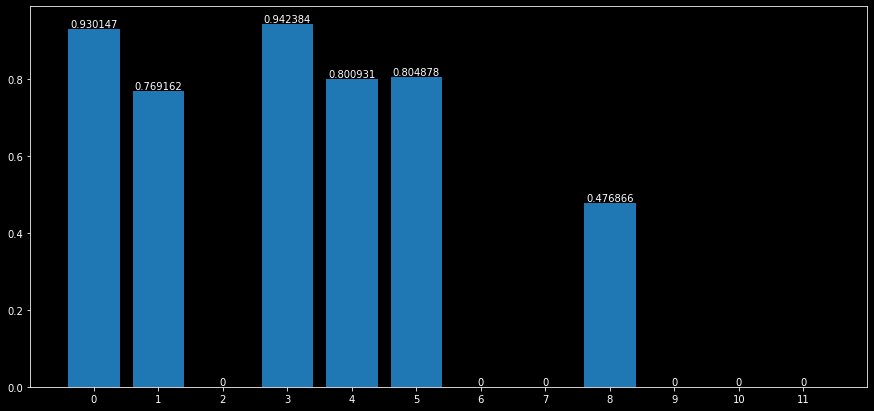

In [34]:
umob_m = calculate_mean_iou(y_test_argmax, umob_y_pred, num_class)

### Plotting Prediction Image

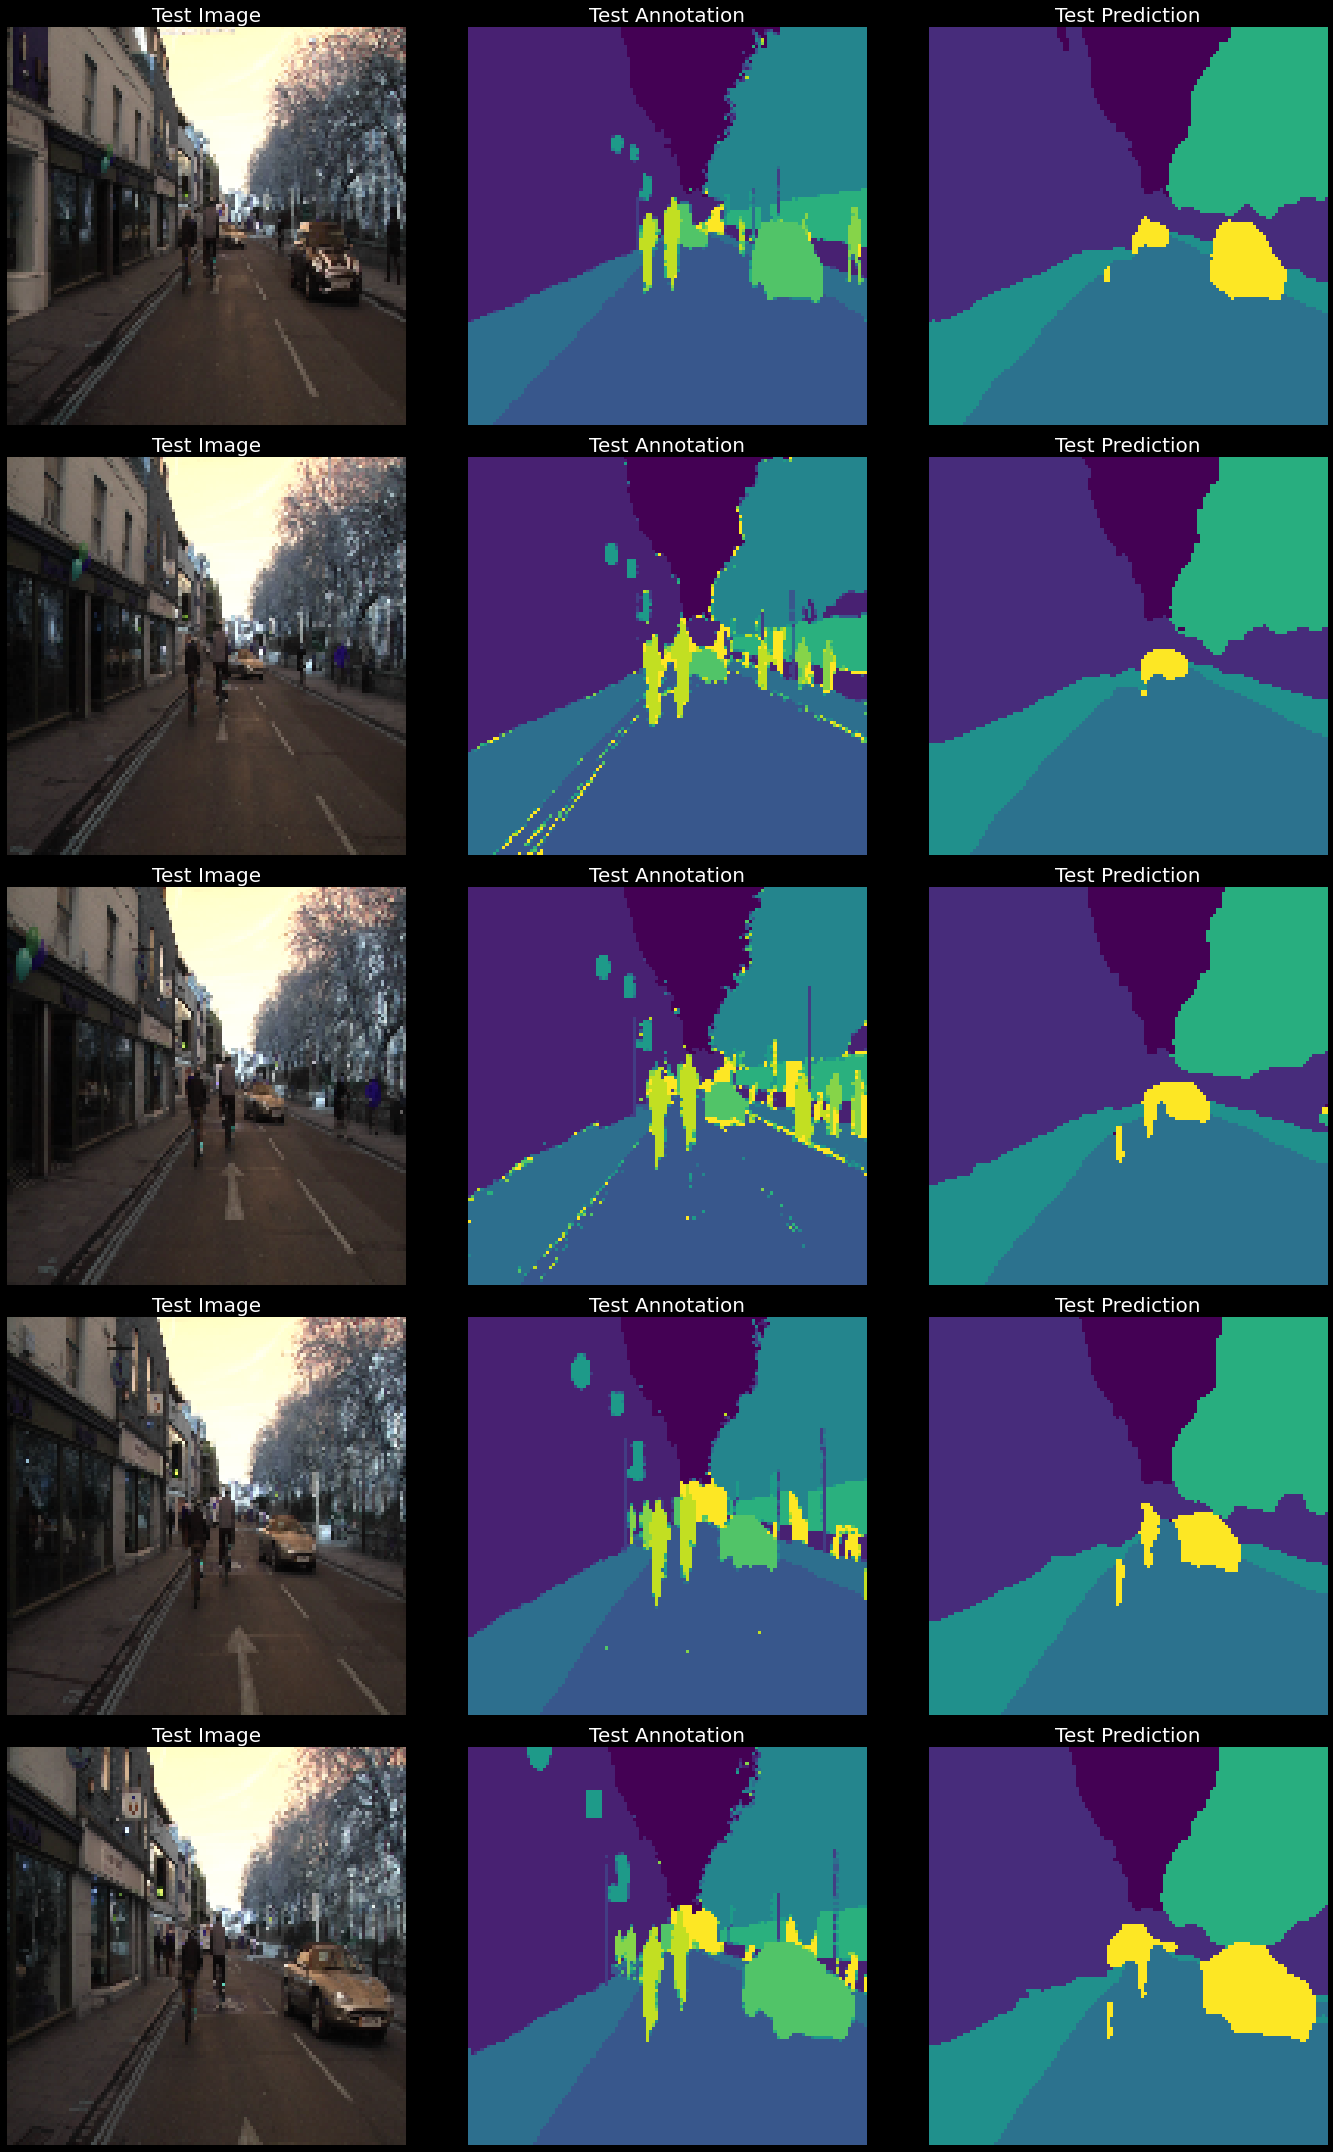

In [33]:
plot_prediction(umob_y_pred)

**Observations:**
- The iou score is pretty high in the classes that its trying to predict, but it's weird that it doesn't even try to predict the some classes.
- I find it pretty weird.

# **Conclution**:
- The Best Test Score is **88.5%**
- The Best Model is **U-Net**
- **FCN8s** Model performs well also
- **U-Net x Mobile-Net v2** needs bigger dataset to perform